# Examples

Below you will find various examples for you to experiment with HOG. For each image, you can modify the `cell_size`, `num_cells_per_block`, and `num_bins` (the number of angular bins in your histograms), to see how those parameters affect the resulting HOG descriptor. These examples, will help you get some intuition for what each parameter does and how they can be *tuned* to pick out the amount of detail required. Below is a list of the available images that you can load:

* cat.jpeg
* jeep1.jpeg
* jeep2.jpeg
* jeep3.jpeg
* man.jpeg
* pedestrian_bike.jpeg
* roundabout.jpeg
* scrabble.jpeg
* shuttle.jpeg
* triangle_tile.jpeg
* watch.jpeg
* woman.jpeg


**NOTE**: If you are running this notebook in the Udacity workspace, there is around a 2 second lag in the interactive plot. This means that if you click in the image to zoom in, it will take about 2 seconds for the plot to refresh. 


The gray scale image has shape:  (424, 640)

HOG Descriptor Parameters:

Window Size: (640, 424)
Cell Size: (8, 8)
Block Size: (16, 16)
Block Stride: (8, 8)
Number of Bins: 9



<IPython.core.display.Javascript object>


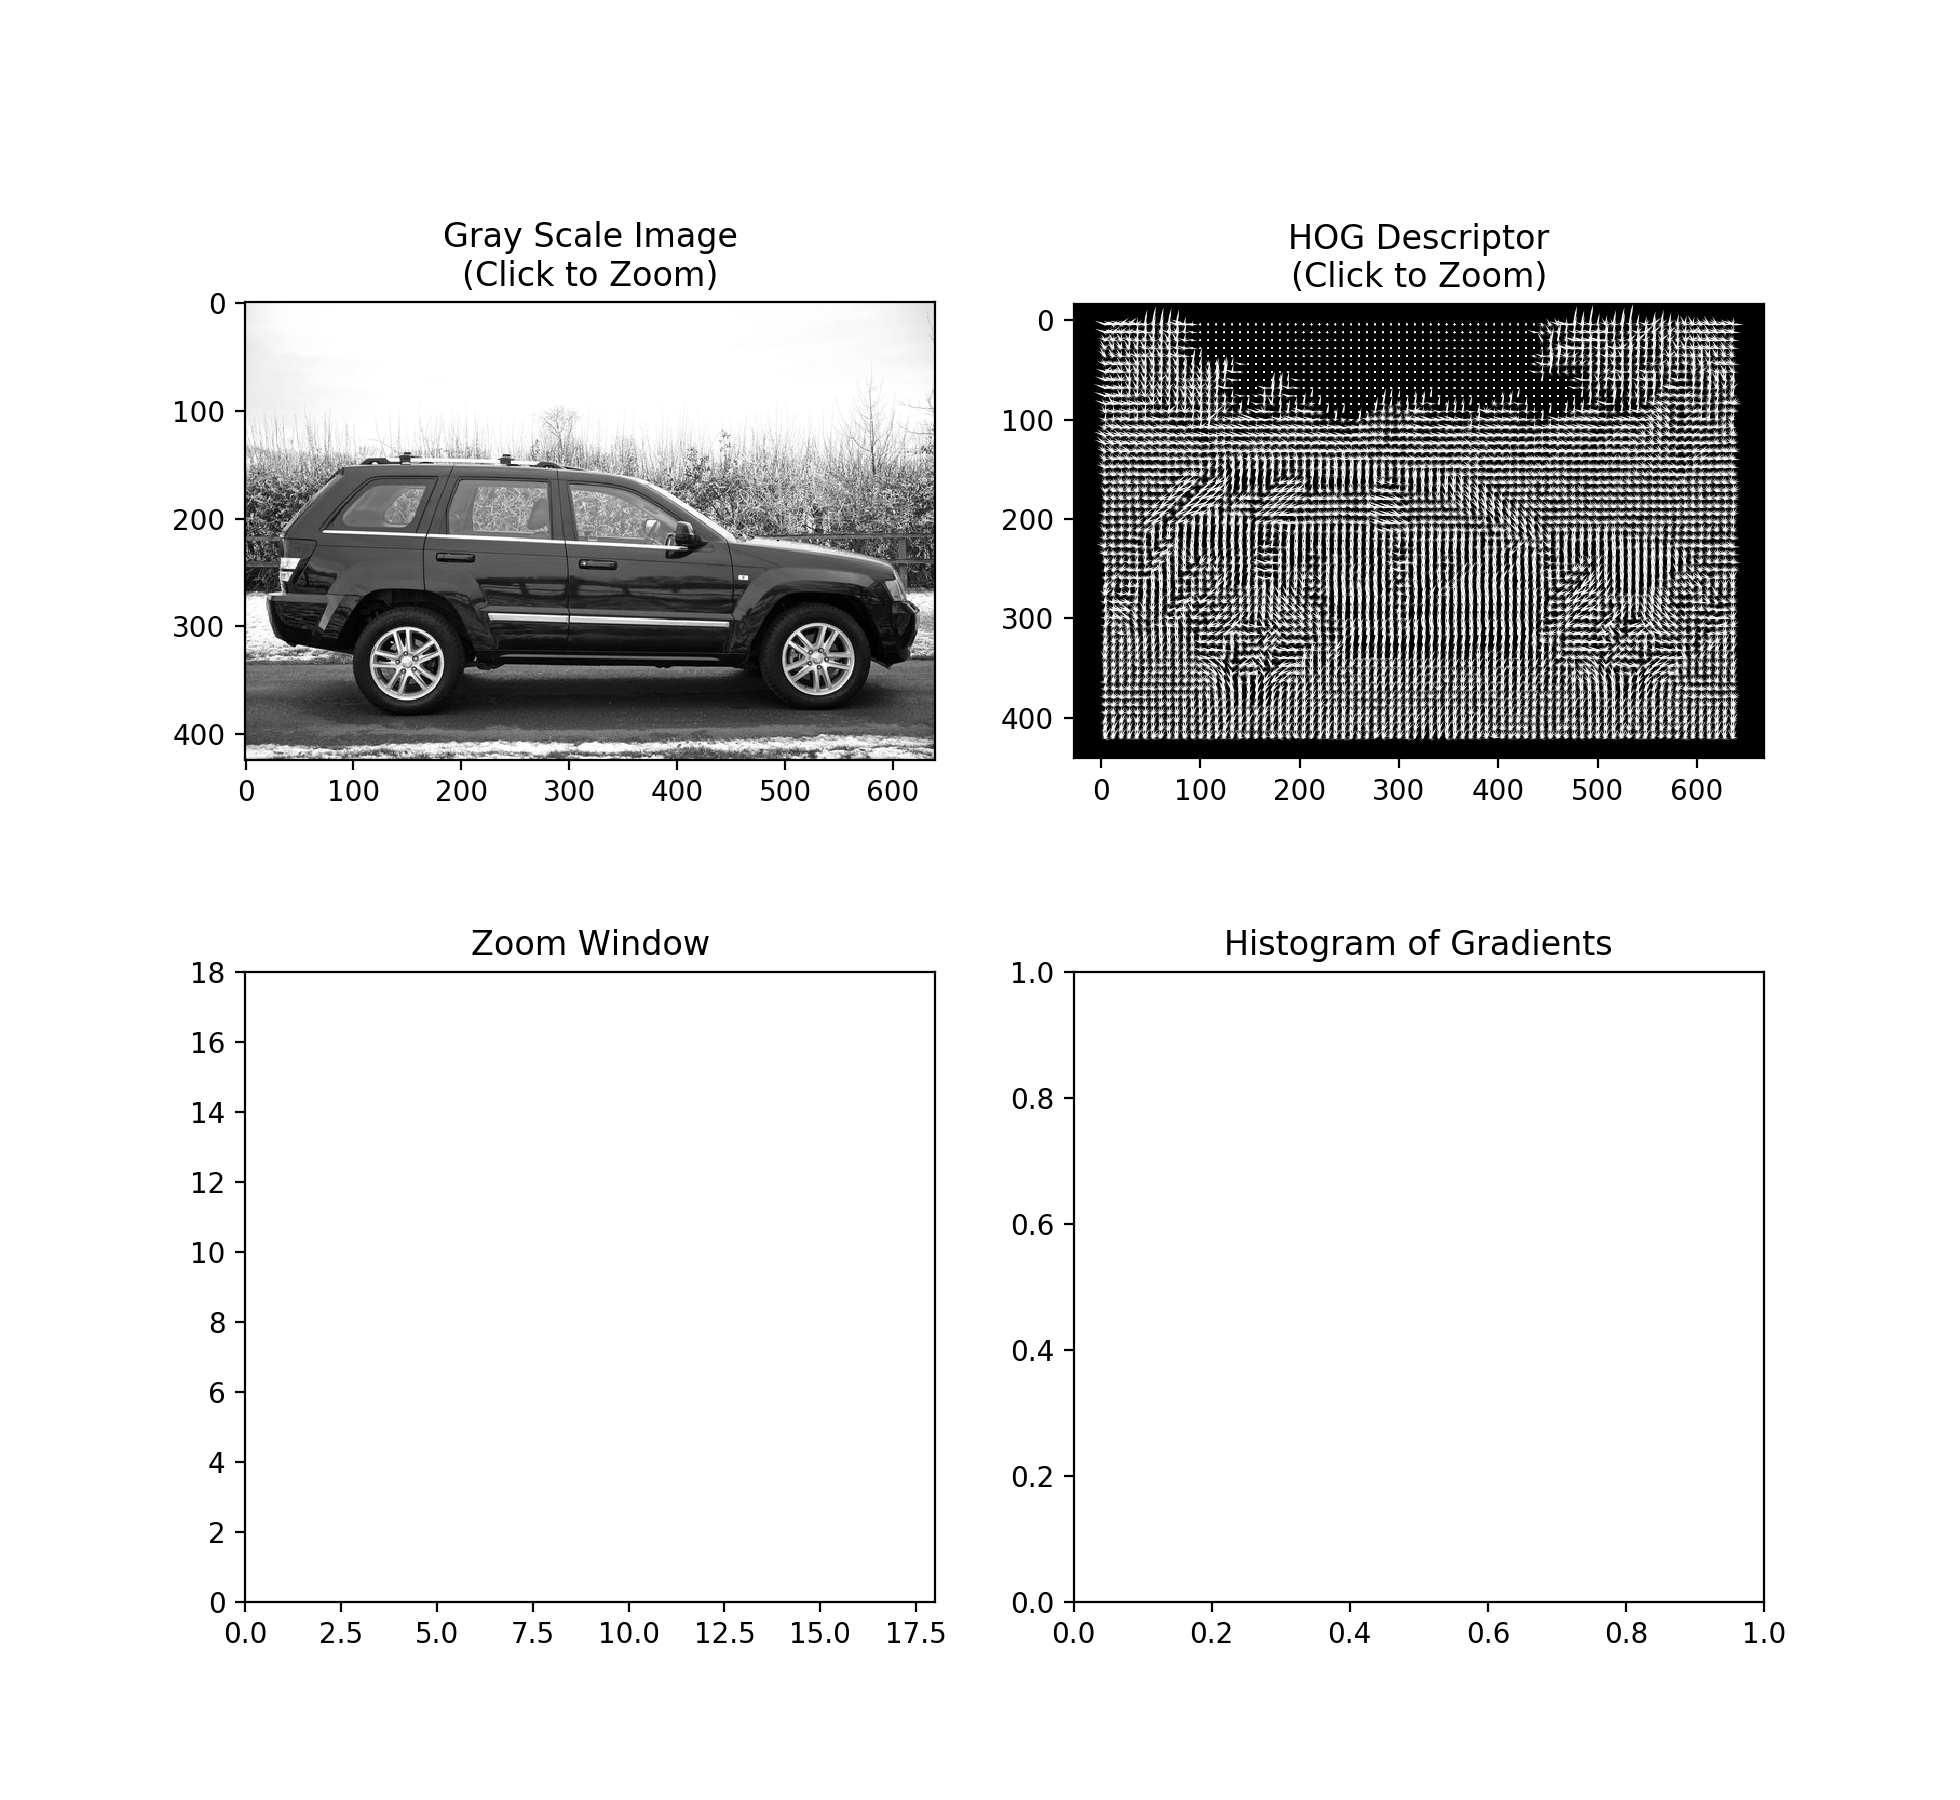

In [1]:
%matplotlib notebook

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set the default figure size
plt.rcParams['figure.figsize'] = [9.8, 9]


# -------------------------- Select the Image and Specify the parameters for our HOG descriptor --------------------------

# Load the image 
image = cv2.imread('./images/jeep2.jpeg')

# Cell Size in pixels (width, height). Must be smaller than the size of the detection window
# and must be chosen so that the resulting Block Size is smaller than the detection window.
cell_size = (8, 8)

# Number of cells per block in each direction (x, y). Must be chosen so that the resulting
# Block Size is smaller than the detection window
num_cells_per_block = (2, 2)

# Number of gradient orientation bins
num_bins = 9

# -------------------------------------------------------------------------------------------------------------------------


# Convert the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Block Size in pixels (width, height). Must be an integer multiple of Cell Size.
# The Block Size must be smaller than the detection window
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

# Calculate the number of cells that fit in our image in the x and y directions
x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

# Horizontal distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (x_cells - num_cells_per_block[0]) / h_stride = integer.
h_stride = 1

# Vertical distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (y_cells - num_cells_per_block[1]) / v_stride = integer.
v_stride = 1

# Block Stride in pixels (horizantal, vertical). Must be an integer multiple of Cell Size
block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

      
# Specify the size of the detection window (Region of Interest) in pixels (width, height).
# It must be an integer multiple of Cell Size and it must cover the entire image. Because
# the detection window must be an integer multiple of cell size, depending on the size of
# your cells, the resulting detection window might be slightly smaller than the image.
# This is perfectly ok.
win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

# Print the shape of the gray scale image for reference
print('\nThe gray scale image has shape: ', gray_image.shape)
print()

# Print the parameters of our HOG descriptor
print('HOG Descriptor Parameters:\n')
print('Window Size:', win_size)
print('Cell Size:', cell_size)
print('Block Size:', block_size)
print('Block Stride:', block_stride)
print('Number of Bins:', num_bins)
print()

# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute the HOG Descriptor for the gray scale image
hog_descriptor = hog.compute(gray_image)

# Calculate the total number of blocks along the width of the detection window
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)

# Calculate the total number of blocks along the height of the detection window
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

# Calculate the total number of elements in the feature vector
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins


# Reshape the feature vector to [blocks_y, blocks_x, num_cells_per_block_x, num_cells_per_block_y, num_bins].
# The blocks_x and blocks_y will be transposed so that the first index (blocks_y) referes to the row number
# and the second index to the column number. This will be useful later when we plot the feature vector, so
# that the feature vector indexing matches the image indexing.
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter
   
# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram). 
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

# Create the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Create a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Plot the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies
        # of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Update all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()